In [1]:
import pandas as pd
# Load the dataset
df = pd.read_csv('sepsis_data_part_1.csv')

In [2]:
# Display the first few rows
print(df.head())

   Patient_ID  Hour    HR  O2Sat  Temp   WBC    SBP  Lactate   DBP  \
0       17072     0   NaN    NaN   NaN   NaN    NaN      NaN   NaN   
1       17072     1  65.0  100.0   NaN   NaN    NaN      NaN   NaN   
2       17072     2  78.0  100.0   NaN   NaN    NaN      NaN   NaN   
3       17072     3  73.0  100.0   NaN   NaN    NaN      NaN   NaN   
4       17072     4  70.0  100.0   NaN  11.3  129.0      NaN  69.0   

   Creatinine  Resp  SepsisLabel  
0         NaN   NaN            0  
1         NaN  16.5            0  
2         NaN   NaN            0  
3         NaN  17.0            0  
4         0.8  14.0            0  


In [3]:
# Select relevant columns
columns = ['Patient_ID', 'Temp', 'HR', 'O2Sat', 'WBC', 'SBP', 'DBP', 'Lactate', 'Resp','Hour','Creatinine']
df = df[columns]

# Display the selected columns
print(df.head())

   Patient_ID  Temp    HR  O2Sat   WBC    SBP   DBP  Lactate  Resp  Hour  \
0       17072   NaN   NaN    NaN   NaN    NaN   NaN      NaN   NaN     0   
1       17072   NaN  65.0  100.0   NaN    NaN   NaN      NaN  16.5     1   
2       17072   NaN  78.0  100.0   NaN    NaN   NaN      NaN   NaN     2   
3       17072   NaN  73.0  100.0   NaN    NaN   NaN      NaN  17.0     3   
4       17072   NaN  70.0  100.0  11.3  129.0  69.0      NaN  14.0     4   

   Creatinine  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         0.8  


In [4]:
df.tail()

,Patient_ID,Temp,HR,O2Sat,WBC,SBP,DBP,Lactate,Resp,Hour,Creatinine
174332,8269,NaN,114.0,100.0,NaN,83.0,NaN,NaN,12.0,13,NaN
174333,8269,NaN,116.0,100.0,NaN,85.0,NaN,NaN,19.0,14,NaN
174334,8269,NaN,125.0,100.0,NaN,100.0,NaN,NaN,13.0,15,NaN
174335,8269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN
174336,8269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN


In [5]:
unique_patients_count = df['Patient_ID'].nunique()
print("Total unique patients:", unique_patients_count)


Total unique patients: 4516


In [6]:
from sklearn.impute import KNNImputer

# Separate numeric and non-numeric columns
numeric_cols = ['Temp', 'HR', 'O2Sat', 'WBC', 'SBP', 'DBP', 'Lactate', 'Resp','Creatinine']

In [7]:
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

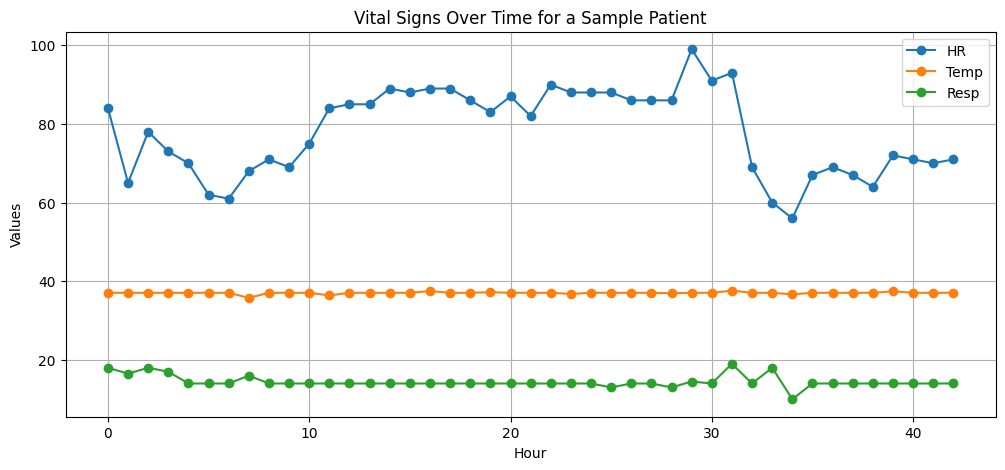

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a sample patient
sample_patient = df[df['Patient_ID'] == df['Patient_ID'].iloc[0]]

# Sort values by Hour
sample_patient = sample_patient.sort_values(by="Hour")

# Plot vital signs over time
plt.figure(figsize=(12, 5))
for col in ["HR", "Temp", "Resp"]:
    if col in df.columns:
        plt.plot(sample_patient["Hour"], sample_patient[col], label=col, marker='o')

plt.title("Vital Signs Over Time for a Sample Patient")
plt.xlabel("Hour")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

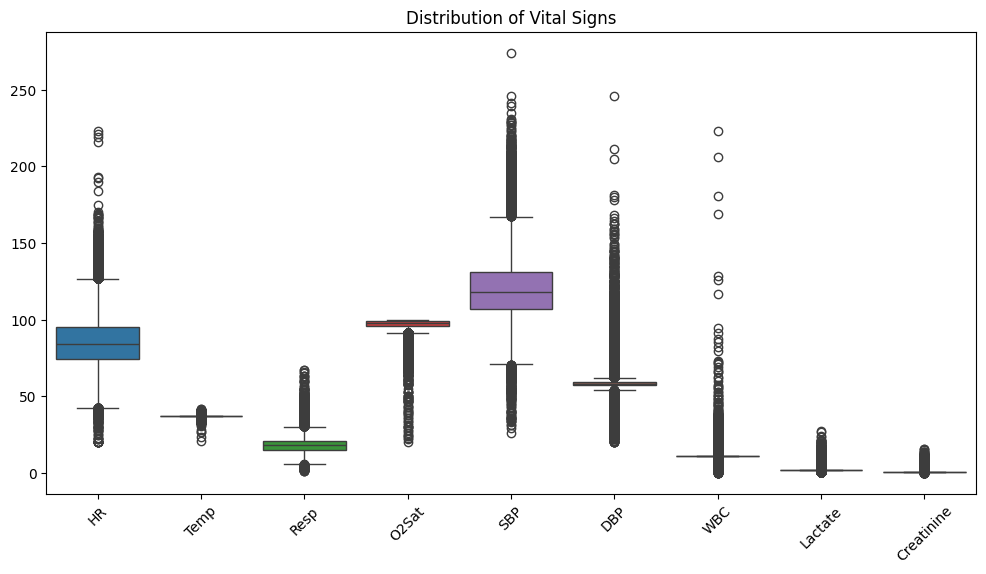

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["HR", "Temp", "Resp", "O2Sat", "SBP", "DBP", "WBC", "Lactate", "Creatinine"]])
plt.xticks(rotation=45)
plt.title("Distribution of Vital Signs")
plt.show()


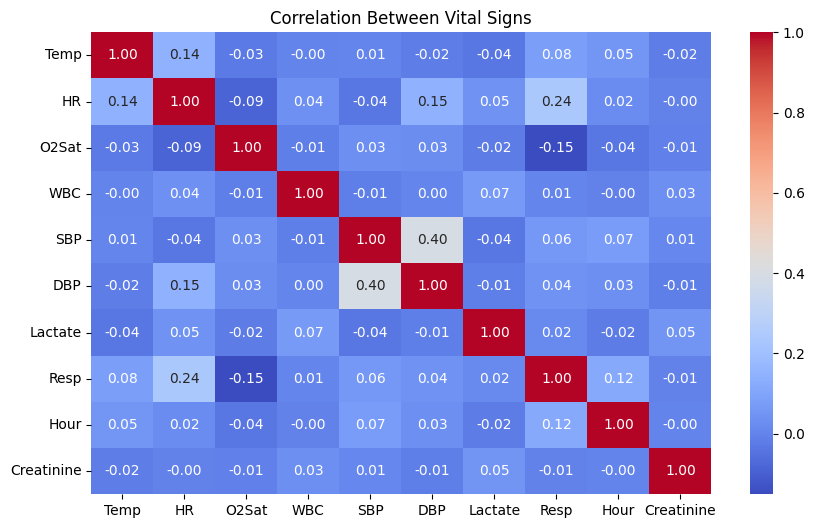

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["Patient_ID"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Vital Signs")
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

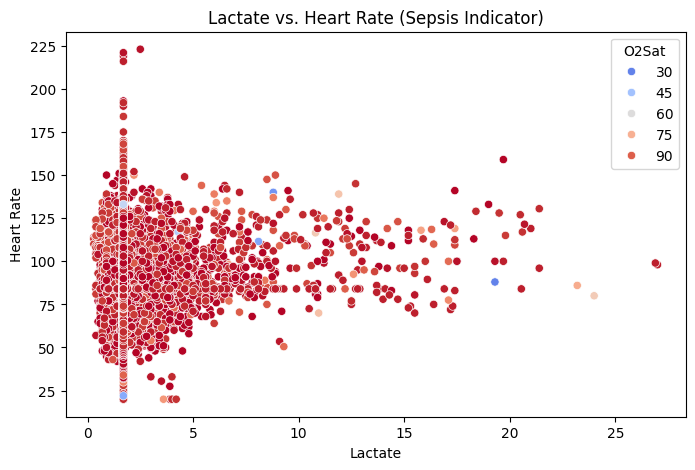

In [11]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Lactate"], y=df["HR"], hue=df["O2Sat"], palette="coolwarm")
plt.title("Lactate vs. Heart Rate (Sepsis Indicator)")
plt.xlabel("Lactate")
plt.ylabel("Heart Rate")
plt.colorbar(label="O2 Saturation")
plt.show()


In [12]:
# Check for remaining missing values
print(df.isnull().sum())

Patient_ID    0
Temp          0
HR            0
O2Sat         0
WBC           0
SBP           0
DBP           0
Lactate       0
Resp          0
Hour          0
Creatinine    0
dtype: int64


In [13]:
import pandas as pd

# Define the stricter sepsis condition function
def sepsis_condition(row):
    return (
        (row['Temp'] > 39) or (row['Temp'] < 35) or  # Stricter temperature
        (row['HR'] > 100) or  # Higher heart rate threshold
        (row['Resp'] > 25) or  # Stricter respiratory rate
        (row['WBC'] > 15) or (row['WBC'] < 3) or  # Adjusted WBC
        (row['SBP'] < 85) or  # Lower SBP
        (row['Lactate'] > 3.0) or  # Higher lactate
        (row['Creatinine'] > 1.5)  # Higher Creatinine
    )

# Apply the condition to create a new column
df['Sepsis_Condition'] = df.apply(sepsis_condition, axis=1).astype(int)  # 1 if True, 0 if False

# Count the number of times each patient meets the sepsis condition
sepsis_counts = df.groupby('Patient_ID')['Sepsis_Condition'].sum()

# Create the final label: if a patient meets the sepsis condition at least 3 times → Sepsis (1), else → Non-Sepsis (0)
df['Final_Sepsis_Label'] = df['Patient_ID'].map(lambda x: 1 if sepsis_counts[x] > 3  else 0)

# Print the distribution of Sepsis (1) and Non-Sepsis (0)
sepsis_distribution = df[['Patient_ID', 'Final_Sepsis_Label']].drop_duplicates()['Final_Sepsis_Label'].value_counts()

# Ensure both labels (0 and 1) appear in the output
sepsis_distribution = sepsis_distribution.reindex([0, 1], fill_value=0)

print(sepsis_distribution)


Final_Sepsis_Label
0    1844
1    2672
Name: count, dtype: int64


In [14]:
from sklearn.preprocessing import StandardScaler

# Normalize numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display the normalized data
print(df.head())

   Patient_ID     Temp        HR     O2Sat       WBC       SBP       DBP  \
0       17072  0.02033 -0.063978  0.243775 -0.038481 -0.117232 -0.090285   
1       17072  0.02033 -1.234836  0.978021 -0.038481 -0.117232 -0.090285   
2       17072  0.02033 -0.433723  0.978021 -0.038481 -0.117232 -0.090285   
3       17072  0.02033 -0.741843  0.978021 -0.038481 -0.117232 -0.090285   
4       17072  0.02033 -0.926715  0.978021  0.167901  0.443295  1.128960   

    Lactate      Resp  Hour  Creatinine  Sepsis_Condition  Final_Sepsis_Label  
0 -0.054751 -0.131080     0   -0.081523                 0                   0  
1 -0.054751 -0.425034     1   -0.081523                 0                   0  
2 -0.054751 -0.131080     2   -0.081523                 0                   0  
3 -0.054751 -0.327049     3   -0.081523                 0                   0  
4 -0.054751 -0.914957     4   -0.340086                 0                   0  


In [15]:
# Convert Patient_ID to categorical
df['Patient_ID'] = df['Patient_ID'].astype('category').cat.codes

# Display the updated DataFrame
print(df.head())

   Patient_ID     Temp        HR     O2Sat       WBC       SBP       DBP  \
0        3805  0.02033 -0.063978  0.243775 -0.038481 -0.117232 -0.090285   
1        3805  0.02033 -1.234836  0.978021 -0.038481 -0.117232 -0.090285   
2        3805  0.02033 -0.433723  0.978021 -0.038481 -0.117232 -0.090285   
3        3805  0.02033 -0.741843  0.978021 -0.038481 -0.117232 -0.090285   
4        3805  0.02033 -0.926715  0.978021  0.167901  0.443295  1.128960   

    Lactate      Resp  Hour  Creatinine  Sepsis_Condition  Final_Sepsis_Label  
0 -0.054751 -0.131080     0   -0.081523                 0                   0  
1 -0.054751 -0.425034     1   -0.081523                 0                   0  
2 -0.054751 -0.131080     2   -0.081523                 0                   0  
3 -0.054751 -0.327049     3   -0.081523                 0                   0  
4 -0.054751 -0.914957     4   -0.340086                 0                   0  


In [16]:
# Create a time index for each patient
df['time_idx'] = df.groupby('Patient_ID').cumcount()

# Display the updated DataFrame
print(df.head())

   Patient_ID     Temp        HR     O2Sat       WBC       SBP       DBP  \
0        3805  0.02033 -0.063978  0.243775 -0.038481 -0.117232 -0.090285   
1        3805  0.02033 -1.234836  0.978021 -0.038481 -0.117232 -0.090285   
2        3805  0.02033 -0.433723  0.978021 -0.038481 -0.117232 -0.090285   
3        3805  0.02033 -0.741843  0.978021 -0.038481 -0.117232 -0.090285   
4        3805  0.02033 -0.926715  0.978021  0.167901  0.443295  1.128960   

    Lactate      Resp  Hour  Creatinine  Sepsis_Condition  Final_Sepsis_Label  \
0 -0.054751 -0.131080     0   -0.081523                 0                   0   
1 -0.054751 -0.425034     1   -0.081523                 0                   0   
2 -0.054751 -0.131080     2   -0.081523                 0                   0   
3 -0.054751 -0.327049     3   -0.081523                 0                   0   
4 -0.054751 -0.914957     4   -0.340086                 0                   0   

   time_idx  
0         0  
1         1  
2         2  


In [17]:
df.tail()

,Patient_ID,Temp,HR,O2Sat,WBC,SBP,DBP,Lactate,Resp,Hour,Creatinine,Sepsis_Condition,Final_Sepsis_Label,time_idx
174332,1867,0.02033,1.784744,0.978021,-0.038481,-1.900729,-0.090285,-0.054751,-1.306896,13,-0.081523,1,1,13
174333,1867,0.02033,1.907993,0.978021,-0.038481,-1.798814,-0.090285,-0.054751,0.064889,14,-0.081523,1,1,14
174334,1867,0.02033,2.462609,0.978021,-0.038481,-1.034459,-0.090285,-0.054751,-1.110927,15,-0.081523,1,1,15
174335,1867,0.02033,-0.063978,0.243775,-0.038481,-0.117232,-0.090285,-0.054751,-0.131080,16,-0.081523,0,1,16
174336,1867,0.02033,-0.063978,0.243775,-0.038481,-0.117232,-0.090285,-0.054751,-0.131080,17,-0.081523,0,1,17


In [26]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
from pytorch_forecasting import TimeSeriesDataSet

df['Patient_ID'] = df['Patient_ID'].astype(str)

# Define the TimeSeriesDataSet
max_encoder_length = 30  # Length of historical data
max_prediction_length = 10  # Length of prediction horizon

training = TimeSeriesDataSet(
    data=df,
    time_idx="time_idx",
    target="Final_Sepsis_Label",  # Use the final sepsis classification column
    group_ids=["Patient_ID"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Patient_ID"],
    time_varying_known_reals=numeric_cols + ['time_idx'],
    time_varying_unknown_reals=["Final_Sepsis_Label"],  # Updated target column
    target_normalizer=None,  # No normalization for binary target
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create a dataloader
train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=0)


/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries.py:1831: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2409 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Patient_ID': '1'}, {'__group_id__Patient_ID': '10'}, {'__group_id__Patient_ID': '1000'}, {'__group_id__Patient_ID': '1001'}, {'__group_id__Patient_ID': '1002'}, {'__group_id__Patient_ID': '1003'}, {'__group_id__Patient_ID': '1004'}, {'__group_id__Patient_ID': '1005'}, {'__group_id__Patient_ID': '1006'}, {'__group_id__Patient_ID': '1007'}]
  warnings.warn(


In [28]:
!pip install torch

In [19]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import CrossEntropy  # Use CrossEntropy for binary classification
import torch

# Define the TFT model with CrossEntropy loss
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,  # Reduce learning rate for better convergence
    hidden_size=128,  # Increase hidden size for better feature learning
    attention_head_size=16,  # More attention heads improve pattern detection
    dropout=0.5,  # Increase dropout to prevent overfitting
    hidden_continuous_size=64,
    output_size=2,  # Binary classification
    loss=CrossEntropy(),  # Apply class weights
    reduce_on_plateau_patience=3,  # Reduce patience for faster learning
)

# Display the model architecture
print(tft)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               16
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'Final_Sepsis_Label', 'group_ids': ['Patient_ID'], 'weight': None, 'max_encoder_length': 30, 'min_encoder_length': 30, 'min_prediction_idx': 0, 'min_prediction_length': 10, 'max_prediction_length': 10, 'static_categoricals': ['Patient_ID'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['Temp', 'HR', 'O2Sat', 'WBC', 'SBP', 'DBP', 'Lactate', 'Resp', 'Creatinine', 'time_idx'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['Final_Sepsis_Label'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalizer': TorchNormalizer(method='identity', 

In [20]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import CrossEntropy

# Calculate class weights (adjust manually if needed)
class_counts = torch.tensor([14568, 38641])  # Example: [No Sepsis, Sepsis] counts
class_weights = 1.0 / class_counts  # Inverse frequency
class_weights = class_weights / class_weights.sum()  # Normalize

# Define a LightningModule wrapper for TemporalFusionTransformer
class TFTLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        y_hat = output.prediction
        loss = self.model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        y_hat = output.prediction
        val_loss = self.model.loss(y_hat, y)

        # Compute recall manually
        y_pred = torch.argmax(y_hat, dim=1)
        tp = ((y_pred == 1) & (y == 1)).sum().float()
        fn = ((y_pred == 0) & (y == 1)).sum().float()
        recall = tp / (tp + fn + 1e-6)  # Avoid division by zero

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("recall", recall, prog_bar=True)  # Log recall metric
        return val_loss

    def configure_optimizers(self):
        return self.model.configure_optimizers()

# Wrap the TemporalFusionTransformer in the LightningModule
tft_model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,  # Reduce learning rate for better convergence
    hidden_size=128,  # Increase hidden size for better feature learning
    attention_head_size=16,  # More attention heads improve pattern detection
    dropout=0.5,  # Increase dropout to prevent overfitting
    hidden_continuous_size=64,
    output_size=2,  # Binary classification
    loss=CrossEntropy(),  # Apply class weights
    reduce_on_plateau_patience=3,  # Reduce patience for faster learning
)

tft_lightning = TFTLightningModule(tft_model)

# Define early stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=15,  # Increase patience for better training
    verbose=True,
    mode="min",
)

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=5,  # Increase epochs for better learning
    accelerator="cpu",  # Use GPU for faster training
    devices=1,
    gradient_clip_val=0.2,
    callbacks=[early_stop_callback],
)

# Create a validation dataloader
validation_dataloader = training.to_dataloader(train=False, batch_size=256, num_workers=4)

# Train the model with validation
trainer.fit(tft_lightning, train_dataloader, validation_dataloader)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smalle

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 86. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [21]:
# Check class distribution
print(df['Final_Sepsis_Label'].value_counts())

Final_Sepsis_Label
1    115795
0     58542
Name: count, dtype: int64


In [23]:
# Save the model checkpoint after training
trainer.save_checkpoint("sepsis_tft_model.ckpt")

In [24]:
# Cell 1: Load the trained model
import torch

# Load the trained model
tft_loaded = TFTLightningModule.load_from_checkpoint("sepsis_tft_model.ckpt", model=tft)
# Put model in evaluation mode
tft_loaded.eval()

TFTLightningModule(
  (model): TemporalFusionTransformer(
    	"attention_head_size":               16
    	"categorical_groups":                {}
    	"causal_attention":                  True
    	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'Final_Sepsis_Label', 'group_ids': ['Patient_ID'], 'weight': None, 'max_encoder_length': 30, 'min_encoder_length': 30, 'min_prediction_idx': 0, 'min_prediction_length': 10, 'max_prediction_length': 10, 'static_categoricals': ['Patient_ID'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['Temp', 'HR', 'O2Sat', 'WBC', 'SBP', 'DBP', 'Lactate', 'Resp', 'Creatinine', 'time_idx'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['Final_Sepsis_Label'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'target_normalize

In [25]:
# Cell 2: Create test dataloader
test_dataloader = training.to_dataloader(train=False, batch_size=128, num_workers=0)

In [33]:
import torch
import numpy as np

def get_predictions(model, dataloader):
    """
    Get model predictions and actual labels from a dataloader.

    Handles cases where the target variable `y` might be a tuple.

    Args:
        model: The trained model.
        dataloader: The dataloader to use for prediction.

    Returns:
        A tuple containing predicted labels and actual labels.
    """
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in dataloader:
            # Check if batch is a tuple and extract x and y accordingly
            if isinstance(batch, tuple) and len(batch) == 2:
                x, y = batch
                # If y is a tuple, assume the first element is the target tensor
                if isinstance(y, tuple):
                    y = y[0]
            else:
                # If batch is not a tuple, assume it's a dictionary-like object
                x = batch
                y = batch['target']

            # Get model predictions
            output = model(x)
            y_hat = output.prediction

            # Convert predictions to probabilities and then to binary labels
            probabilities = torch.softmax(y_hat, dim=1)
            pred_labels = torch.argmax(probabilities, dim=1)

            # Store predictions and actuals
            predictions.extend(pred_labels.cpu().numpy())
            actuals.extend(y.cpu().numpy())

    return np.array(predictions), np.array(actuals)

In [36]:
# Get predictions (without patient_ids since we can't reliably extract them)
y_pred, y_true = get_predictions(tft_loaded, test_dataloader)

# Reshape or select elements from y_true to make it 1-dimensional
# Here, I'm taking the first element of each row, adjust if needed
y_true = y_true[:, 0]  # Or another appropriate selection method

# Reshape y_pred to 1-dimensional using argmax to get the predicted class labels
y_pred = np.argmax(y_pred, axis=1)  # Assuming y_pred contains probabilities

# Create a DataFrame without patient_ids
results_df = pd.DataFrame({
    'Index': range(len(y_true)),
    'Actual': y_true,
    'Predicted': y_pred
})

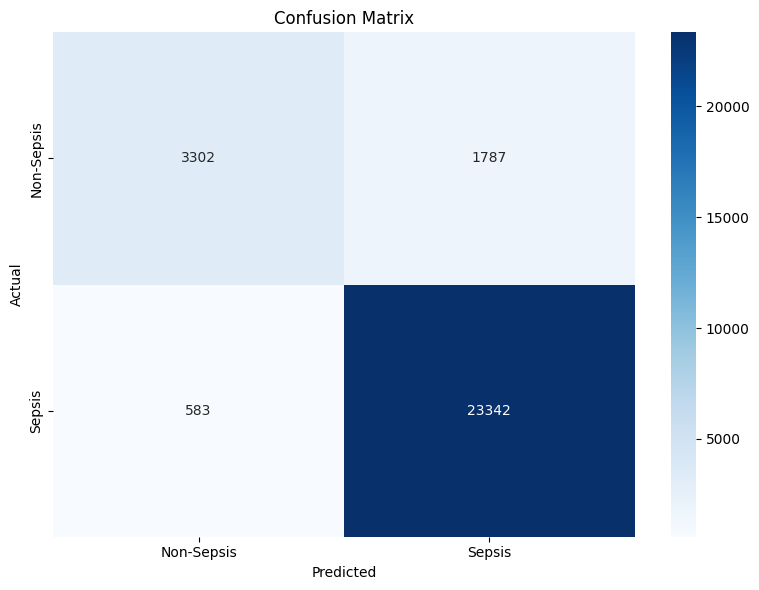

In [37]:
# Cell 5: Create confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Sepsis', 'Sepsis'],
            yticklabels=['Non-Sepsis', 'Sepsis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


In [38]:
# Cell 6: Print classification report
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

# Calculate metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Sepsis', 'Sepsis']))

print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

  Non-Sepsis       0.85      0.65      0.74      5089
      Sepsis       0.93      0.98      0.95     23925

    accuracy                           0.92     29014
   macro avg       0.89      0.81      0.84     29014
weighted avg       0.92      0.92      0.91     29014

Recall (Sensitivity): 0.9756
Precision: 0.9289
F1 Score: 0.9517


<Figure size 1000x600 with 0 Axes>

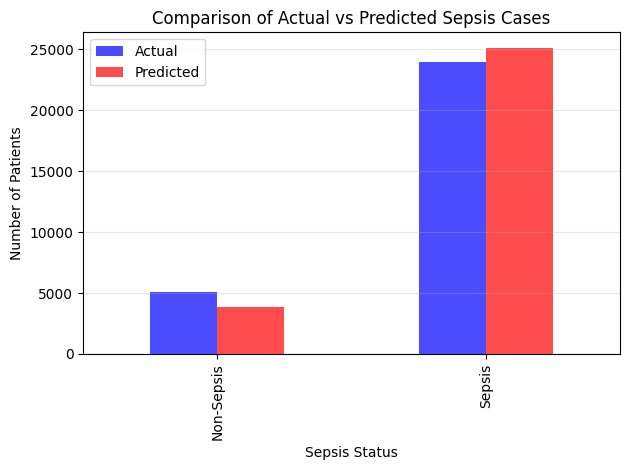

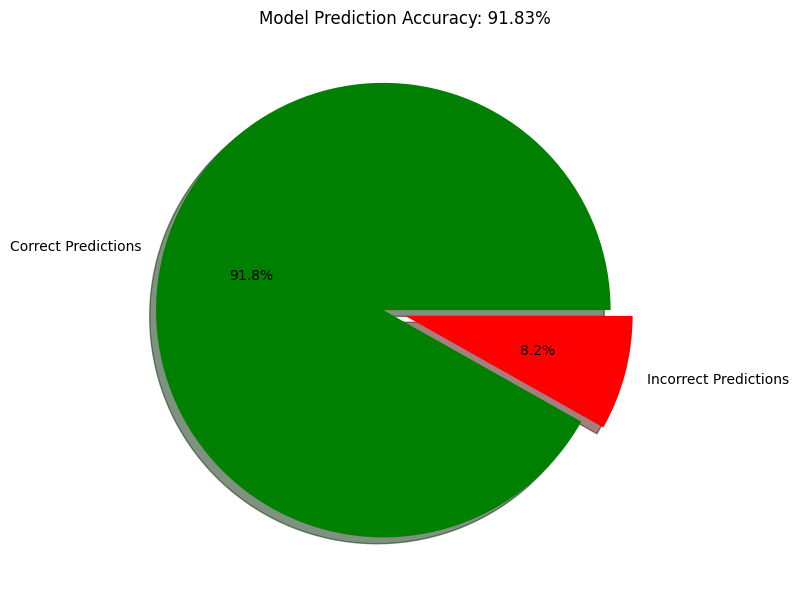

In [43]:
# Cell 7: Create an easy-to-understand prediction vs actual chart
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame for predictions vs. actuals
results_df = pd.DataFrame({
    'Patient_ID': range(len(y_true)),
    'Actual': y_true,
    'Predicted': y_pred
})

# Count the number of actual and predicted cases
sepsis_counts = {
    'Actual': [sum(results_df['Actual'] == 0), sum(results_df['Actual'] == 1)],
    'Predicted': [sum(results_df['Predicted'] == 0), sum(results_df['Predicted'] == 1)]
}

# Create a DataFrame for the counts
counts_df = pd.DataFrame(sepsis_counts, index=['Non-Sepsis', 'Sepsis'])

# Create a bar chart for the counts
plt.figure(figsize=(10, 6))
counts_df.plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.xlabel('Sepsis Status')
plt.ylabel('Number of Patients')
plt.title('Comparison of Actual vs Predicted Sepsis Cases')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('sepsis_counts_comparison.png')
plt.show()

# Create a pie chart to show proportion of correct predictions
correct_predictions = sum(results_df['Actual'] == results_df['Predicted'])
total_predictions = len(results_df)
accuracy = correct_predictions / total_predictions

plt.figure(figsize=(8, 8))
plt.pie([correct_predictions, total_predictions - correct_predictions],
        labels=['Correct Predictions', 'Incorrect Predictions'],
        autopct='%1.1f%%',
        colors=['green', 'red'],
        explode=(0.1, 0),
        shadow=True)
plt.title(f'Model Prediction Accuracy: {accuracy:.2%}')
plt.tight_layout()
plt.savefig('prediction_accuracy_pie.png')
plt.show()

